In [1]:
import pandas as pd
df = pd.read_csv('/Gender, Age, Ethnicity recognition/age_gender.csv')
df.head()
df_regression = df.copy()

In [2]:
df.shape

(23705, 5)

C:\Users\dimav\.conda\envs\my-rdkit-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ethnicity', ylabel='count'>

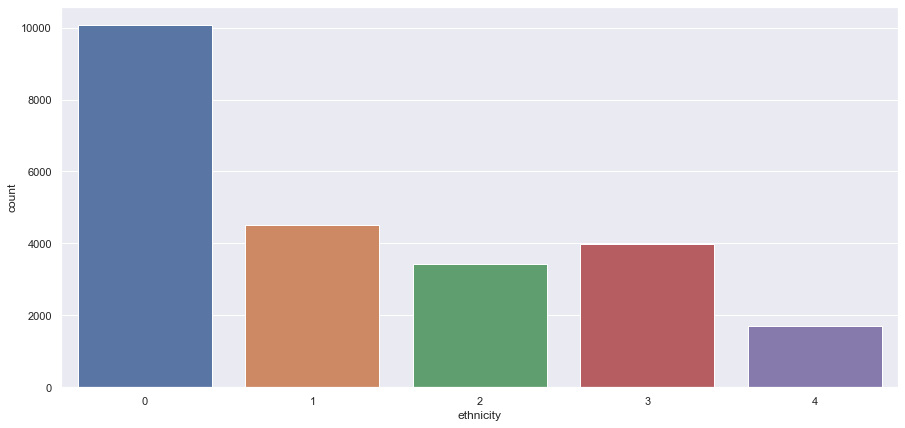

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(df['ethnicity'])

C:\Users\dimav\.conda\envs\my-rdkit-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

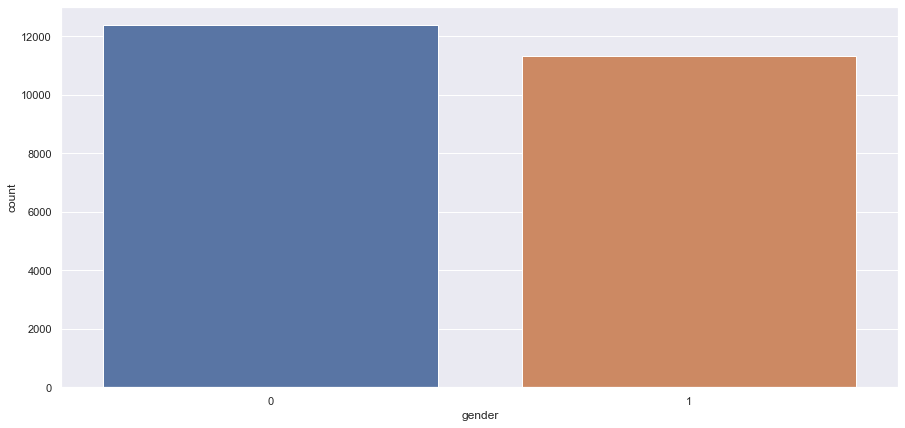

In [4]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(df['gender'])

In [5]:
import plotly.express as px
df_age=df.groupby(['age']).count()
df_age=pd.DataFrame(df_age)
fig = px.line(df_age)
fig.show()

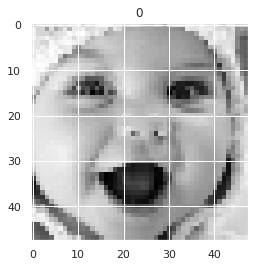

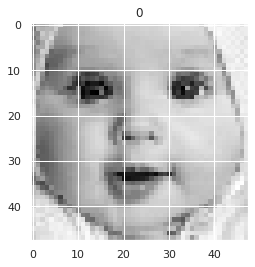

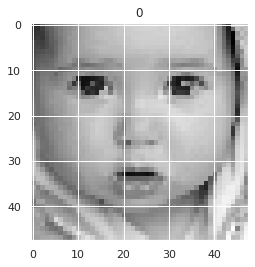

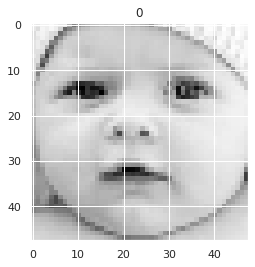

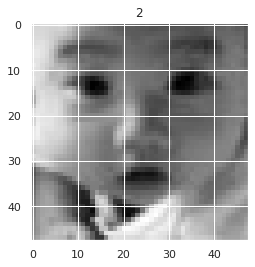

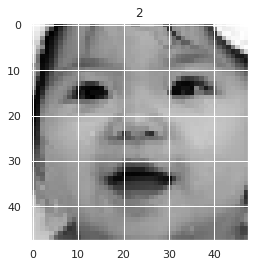

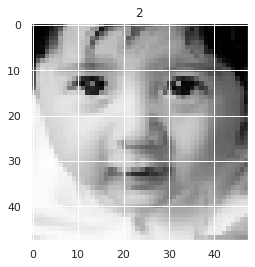

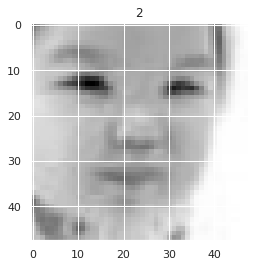

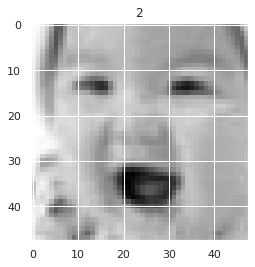

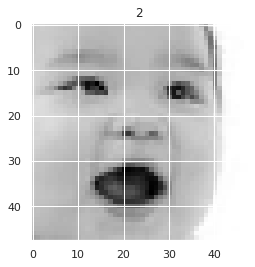

In [6]:
import numpy as np
for i in range(1000,1010):
    image = np.fromstring(df['pixels'][i], sep = ' ', dtype = np.uint8).reshape((48,48))
    plt.title(df['ethnicity'][i])
    plt.imshow(image, cmap ="gray")
    plt.show()

In [233]:
df['age'] = pd.cut(df["age"],bins=[0,3,18,45,64,116],labels=["0-5","5-18","18-45","45-64","64-116"])

In [234]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))
df_regression['pixels'] = df_regression['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

In [8]:
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255
input_shape = X_reshaped.shape[1:] 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Number of age')

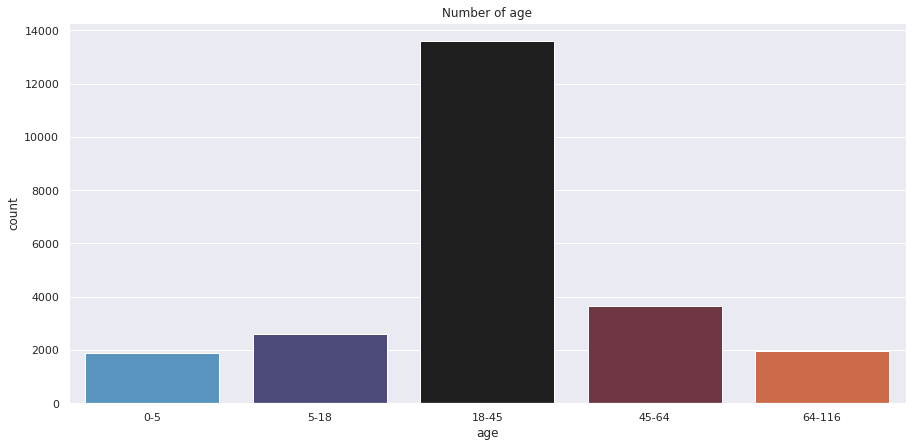

In [9]:
y_age = pd.cut(df["age"],bins=[0,3,18,45,64,116],labels=["0-5","5-18","18-45","45-64","64-116"])
plt.figure(figsize=(15,7))
g = sns.countplot(y_age, palette="icefire")
plt.title("Number of age")

In [10]:
y_ethnicity = df['ethnicity'].values
y_gender = df['gender'].values

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_age = label_encoder.fit_transform(y_age)

In [12]:
from sklearn.model_selection import train_test_split
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_reshaped, y_age, test_size=0.2, random_state=42)
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X_reshaped, y_ethnicity, test_size=0.2, random_state=42)
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X_reshaped, y_gender, test_size=0.2, random_state=42)

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report


In [14]:
def universal_model(num_classes,unit,dropout,activation,loss,metric):
    model = Sequential()
    model.add(Conv2D(unit, kernel_size=(3,3), activation='relu',padding = "same", input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(unit, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(unit, kernel_size=(3,3),padding = "same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(unit, kernel_size=(3,3),padding = "same", activation='relu'))
    model.add(Conv2D(unit, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(unit, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(unit, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(unit, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation= activation,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
    print(model.summary())
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=loss, metrics=[metric])
    return model

In [251]:
def plot_history(history,loss,val_loss,metric,val_metric):
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history[loss], label="Train loss")
    ax_loss.plot(history.epoch, history.history[val_loss], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history[metric], label="Train metric")
    ax_acc.plot(history.epoch, history.history[val_metric], label="Validation metric")
    ax_acc.legend()
    plt.show()

In [16]:
age_model = universal_model(num_classes = 5,unit = 128,dropout = 0.4,activation = 'softmax',loss = 'sparse_categorical_crossentropy',metric = 'accuracy')

2022-02-15 19:34:42.281226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 19:34:42.282302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 19:34:42.282979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 19:34:42.283838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 128)       147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 128)         1

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

In [18]:
history_age = age_model.fit(X_train_age, y_train_age, batch_size=64,
                              epochs = 20, validation_data = (X_test_age,y_test_age), 
                            steps_per_epoch= X_train_age.shape[0] // 64, callbacks= [early_stopping, learning_rate_reduction])

2022-02-15 19:34:45.352991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-02-15 19:34:47.478161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


296/296 [==============================] - 12s 15ms/step - loss: 1.3370 - accuracy: 0.5804 - val_loss: 1.1175 - val_accuracy: 0.6315
Epoch 2/20
296/296 [==============================] - 4s 14ms/step - loss: 1.0117 - accuracy: 0.6502 - val_loss: 0.8763 - val_accuracy: 0.6883
Epoch 3/20
296/296 [==============================] - 4s 14ms/step - loss: 0.8837 - accuracy: 0.6920 - val_loss: 0.7927 - val_accuracy: 0.7201
Epoch 4/20
296/296 [==============================] - 4s 14ms/step - loss: 0.8133 - accuracy: 0.7129 - val_loss: 0.7581 - val_accuracy: 0.7425
Epoch 5/20
296/296 [==============================] - 4s 14ms/step - loss: 0.7625 - accuracy: 0.7319 - val_loss: 0.7136 - val_accuracy: 0.7543
Epoch 6/20
296/296 [==============================] - 4s 14ms/step - loss: 0.7230 - accuracy: 0.7460 - val_loss: 0.7544 - val_accuracy: 0.7254
Epoch 7/20
296/296 [==============================] - 4s 14ms/step - loss: 0.6964 - accuracy: 0.7537 - val_loss: 0.6954 - val_accuracy: 0.7528
Epoch 8/2

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7feae56287a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


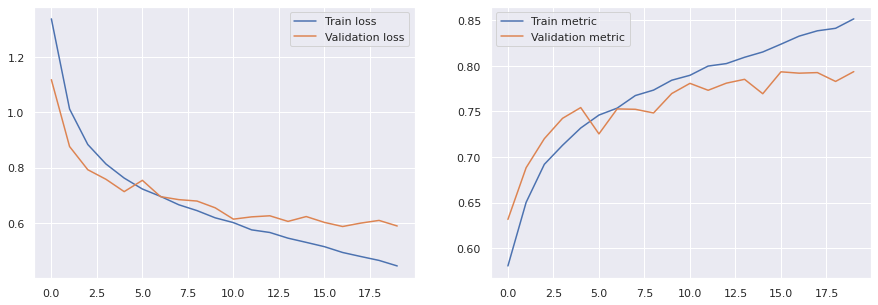

In [252]:
plot_history(history=history_age,loss='loss',val_loss='val_loss',metric='accuracy',val_metric='val_accuracy')

In [21]:
loss, acc = age_model.evaluate(X_test_age, y_test_age, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

149/149 [==============================] - 1s 4ms/step - loss: 0.5896 - accuracy: 0.7937
Test loss: 0.5895984172821045
Test Accuracy: 0.7937144041061401


In [68]:
y_pred_age=np.argmax(age_model.predict(X_test_age), axis=-1)

In [69]:
print(classification_report(y_test_age, y_pred_age))

              precision    recall  f1-score   support

           0       0.86      0.94      0.89       354
           1       0.87      0.90      0.88      2770
           2       0.54      0.55      0.55       719
           3       0.77      0.62      0.69       512
           4       0.68      0.60      0.64       386

    accuracy                           0.79      4741
   macro avg       0.74      0.72      0.73      4741
weighted avg       0.79      0.79      0.79      4741



In [26]:
gender_model = universal_model(num_classes = 1,unit = 128,dropout = 0.4,activation = 'sigmoid',loss = 'binary_crossentropy',metric = 'accuracy')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 128)       1280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 22, 128)       147584    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 22, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 128)       147584    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 128)        

In [27]:
history_gender = gender_model.fit(X_train_gender, y_train_gender, 
                        epochs=20,
                        batch_size=64,
                        callbacks=[early_stopping, learning_rate_reduction],
                        validation_data=(X_test_gender, y_test_gender))

Epoch 1/20
297/297 [==============================] - 6s 16ms/step - loss: 0.6679 - accuracy: 0.7043 - val_loss: 0.5095 - val_accuracy: 0.8093
Epoch 2/20
297/297 [==============================] - 4s 14ms/step - loss: 0.4678 - accuracy: 0.8277 - val_loss: 0.4265 - val_accuracy: 0.8391
Epoch 3/20
297/297 [==============================] - 4s 15ms/step - loss: 0.4032 - accuracy: 0.8543 - val_loss: 0.3797 - val_accuracy: 0.8648
Epoch 4/20
297/297 [==============================] - 4s 15ms/step - loss: 0.3643 - accuracy: 0.8695 - val_loss: 0.3592 - val_accuracy: 0.8673
Epoch 5/20
297/297 [==============================] - 4s 14ms/step - loss: 0.3429 - accuracy: 0.8773 - val_loss: 0.3679 - val_accuracy: 0.8673
Epoch 6/20
297/297 [==============================] - 4s 14ms/step - loss: 0.3173 - accuracy: 0.8887 - val_loss: 0.3289 - val_accuracy: 0.8840
Epoch 7/20
297/297 [==============================] - 4s 14ms/step - loss: 0.3022 - accuracy: 0.8950 - val_loss: 0.3167 - val_accuracy: 0.8888

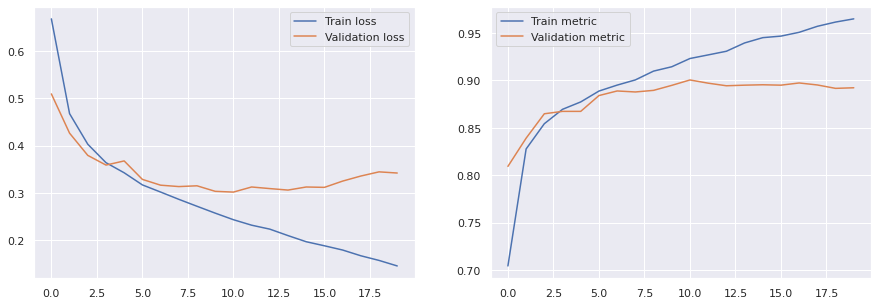

In [253]:
plot_history(history=history_gender,loss='loss',val_loss='val_loss',metric='accuracy',val_metric='val_accuracy')

In [30]:
loss, acc = gender_model.evaluate(X_test_gender, y_test_gender, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

149/149 [==============================] - 1s 4ms/step - loss: 0.3424 - accuracy: 0.8922
Test loss: 0.3423907160758972
Test Accuracy: 0.8922168612480164


In [56]:
y_pred_gender = (gender_model.predict(X_test_gender)>0.5).astype("int32")

In [57]:
print(classification_report(y_test_gender, y_pred_gender))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2468
           1       0.86      0.92      0.89      2273

    accuracy                           0.89      4741
   macro avg       0.89      0.89      0.89      4741
weighted avg       0.89      0.89      0.89      4741



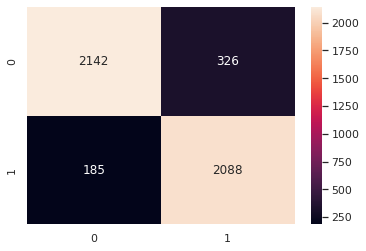

In [263]:
cm = confusion_matrix(y_test_gender, y_pred_gender)
sns.heatmap(cm, cbar=True, annot=True, fmt='d');

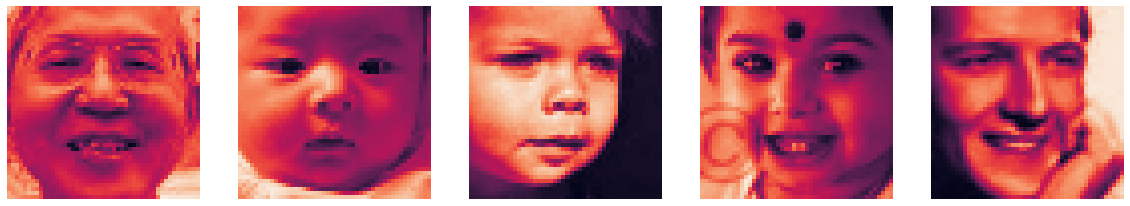

In [72]:
y_pred = y_pred_gender.reshape(y_pred.shape[0])
X_fp = X_test_gender[(y_pred == 1) & (y_test_gender == 0)] 
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    random_choice = np.random.choice(len(X_fp))
    axes[i].imshow(X_fp[random_choice].reshape(48, 48))
    axes[i].axis('off')

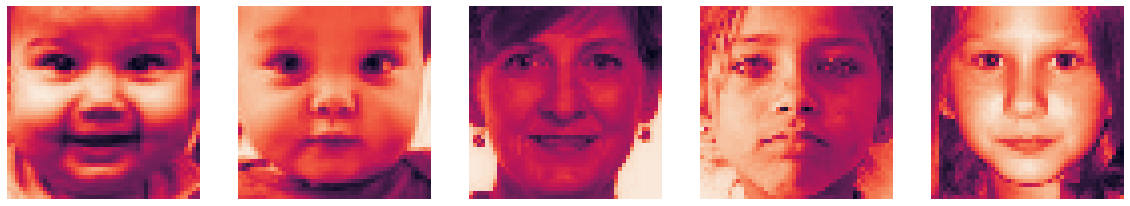

In [74]:
X_fn = X_test_gender[(y_pred == 0) & (y_test_gender == 1)]  
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    random_choice = np.random.choice(len(X_fn))
    axes[i].imshow(X_fn[random_choice].reshape(48, 48))
    axes[i].axis('off')

In [31]:
ethnicity_model  = universal_model(num_classes = 5,unit = 128,dropout = 0.4,activation = 'softmax',loss = 'sparse_categorical_crossentropy',metric = 'accuracy')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 128)       1280      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 22, 128)       147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 22, 22, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 128)       147584    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 9, 9, 128)        

In [32]:
history_ethnicity = ethnicity_model.fit(X_train_ethnicity, y_train_ethnicity, 
                        epochs=20,
                        batch_size=64,
                        callbacks=[early_stopping, learning_rate_reduction],
                        validation_data=(X_test_ethnicity, y_test_ethnicity))

Epoch 1/20
297/297 [==============================] - 5s 15ms/step - loss: 1.5156 - accuracy: 0.4506 - val_loss: 1.3034 - val_accuracy: 0.5267
Epoch 2/20
297/297 [==============================] - 4s 14ms/step - loss: 1.1751 - accuracy: 0.5961 - val_loss: 1.0111 - val_accuracy: 0.6579
Epoch 3/20
297/297 [==============================] - 4s 14ms/step - loss: 0.9865 - accuracy: 0.6810 - val_loss: 0.9083 - val_accuracy: 0.7053
Epoch 4/20
297/297 [==============================] - 4s 15ms/step - loss: 0.9050 - accuracy: 0.7123 - val_loss: 0.8366 - val_accuracy: 0.7361
Epoch 5/20
297/297 [==============================] - 4s 14ms/step - loss: 0.8484 - accuracy: 0.7342 - val_loss: 0.8047 - val_accuracy: 0.7454
Epoch 6/20
297/297 [==============================] - 4s 14ms/step - loss: 0.8015 - accuracy: 0.7517 - val_loss: 0.7649 - val_accuracy: 0.7617
Epoch 7/20
297/297 [==============================] - 4s 14ms/step - loss: 0.7574 - accuracy: 0.7661 - val_loss: 0.7696 - val_accuracy: 0.7560

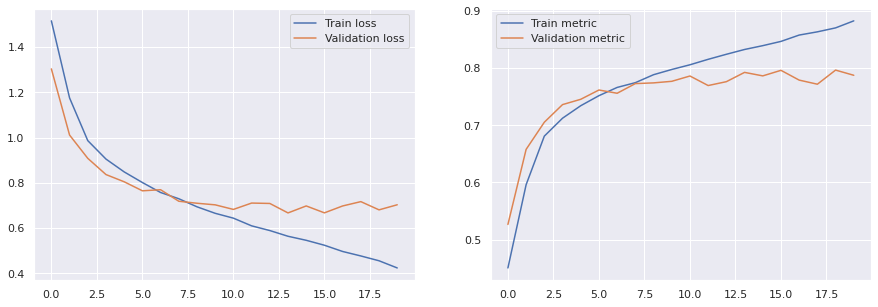

In [254]:
plot_history(history=history_ethnicity,loss='loss',val_loss='val_loss',metric='accuracy',val_metric='val_accuracy')

In [35]:
loss, acc = ethnicity_model.evaluate(X_test_ethnicity, y_test_ethnicity, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

149/149 [==============================] - 1s 4ms/step - loss: 0.7032 - accuracy: 0.7874
Test loss: 0.7031906843185425
Test Accuracy: 0.7873866558074951


In [64]:
y_pred_ethnicity=np.argmax(ethnicity_model.predict(X_test_ethnicity), axis=-1)

In [65]:
print(classification_report(y_test_ethnicity, y_pred_ethnicity))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2047
           1       0.81      0.86      0.83       904
           2       0.82      0.85      0.84       657
           3       0.73      0.76      0.74       804
           4       0.32      0.27      0.29       329

    accuracy                           0.79      4741
   macro avg       0.71      0.71      0.71      4741
weighted avg       0.78      0.79      0.78      4741



In [243]:
def face_prediction(image):
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    age_predict = np.argmax(age_model.predict(x), axis=-1)
    if age_predict == 0:
        age_predict = "0-5"
    if age_predict == 1:
        age_predict = "5-18"
    if age_predict == 2:
        age_predict = "18-45"
    if age_predict == 3:
        age_predict = "45-64"
    if age_predict == 4:
        age_predict = "64-116"
    gender_predict = (gender_model.predict(x)>0.5).astype("int32")
    ethnicity_predict = np.argmax(ethnicity_model.predict(x), axis=-1)
    plt.imshow(image)
    plt.title((age_predict,gender_predict, ethnicity_predict))
    plt.axis('off')

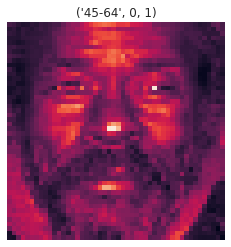

In [244]:
random_face = np.random.choice(len(df))
age = df['age'][random_face]
ethnicity = df['ethnicity'][random_face]
gender = df['gender'][random_face]
plt.imshow(df['pixels'][random_face])
plt.title((age,gender, ethnicity))
plt.axis('off')

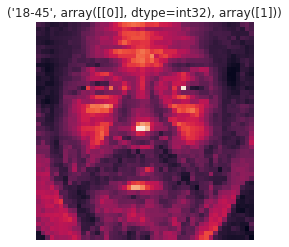

In [245]:
face_prediction(df['pixels'][random_face])

age regression

In [188]:
df_regression.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [189]:
y_age_regression = df_regression['age'].values

In [190]:
X_train_age_regression, X_test_age_regression, y_train_age_regression, y_test_age_regression = train_test_split(X_reshaped, y_age_regression, test_size=0.2, random_state=42)

In [246]:
age_model_regression = universal_model(num_classes = 1,unit = 256,dropout = 0.5,activation = tf.keras.activations.linear,loss = 'mse',metric = 'mae')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 48, 48, 256)       2560      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 22, 22, 256)       590080    
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 22, 22, 256)       590080    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 11, 11, 256)       590080    
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 9, 9, 256)        

In [247]:
history_age_regression = age_model_regression.fit(X_train_age_regression, y_train_age_regression, 
                        epochs=20,
                        batch_size=64,
                        callbacks=[early_stopping, learning_rate_reduction],
                        validation_data=(X_test_age_regression, y_test_age_regression))

Epoch 1/20
297/297 [==============================] - 11s 31ms/step - loss: 488.8295 - mae: 17.0533 - val_loss: 337.6371 - val_mae: 14.6045
Epoch 2/20
297/297 [==============================] - 9s 29ms/step - loss: 337.7588 - mae: 14.1533 - val_loss: 259.0060 - val_mae: 12.7974
Epoch 3/20
297/297 [==============================] - 9s 29ms/step - loss: 269.6156 - mae: 12.5357 - val_loss: 203.7487 - val_mae: 11.0622
Epoch 4/20
297/297 [==============================] - 9s 29ms/step - loss: 223.2457 - mae: 11.2560 - val_loss: 173.4995 - val_mae: 9.7236
Epoch 5/20
297/297 [==============================] - 9s 29ms/step - loss: 196.2236 - mae: 10.4364 - val_loss: 253.2822 - val_mae: 12.8239
Epoch 6/20
297/297 [==============================] - 9s 29ms/step - loss: 183.7767 - mae: 10.0646 - val_loss: 204.1449 - val_mae: 11.4654
Epoch 7/20
297/297 [==============================] - 8s 29ms/step - loss: 178.3131 - mae: 9.8555 - val_loss: 156.3491 - val_mae: 9.6120
Epoch 8/20
297/297 [=========

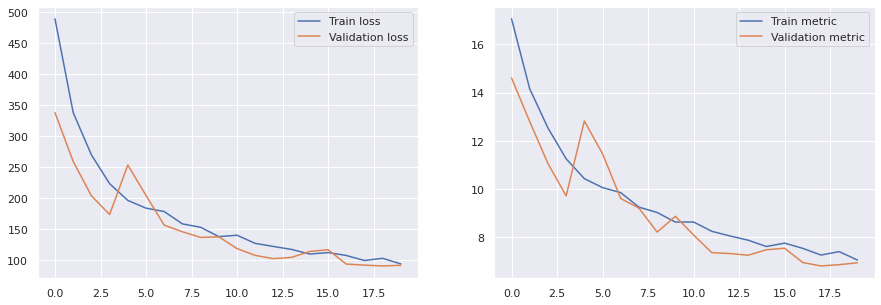

In [255]:
plot_history(history=history_age_regression,loss='loss',val_loss='val_loss',metric='mae',val_metric='val_mae')

In [256]:
valid_score = age_model_regression.evaluate(X_test_age_regression, y_test_age_regression, verbose=1)
y_pred = age_model_regression.predict(X_test_age_regression)

149/149 [==============================] - 1s 6ms/step - loss: 91.6799 - mae: 6.9505


In [257]:
from sklearn.metrics import mean_absolute_error
print("MAE: {}".format(mean_absolute_error(y_test_age_regression, y_pred)))

MAE: 6.950478681008591


In [258]:
def face_prediction(image):
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    age_predict = int(age_model_regression.predict(x))
    gender_predict = (gender_model.predict(x)>0.5).astype("int32")
    ethnicity_predict = np.argmax(ethnicity_model.predict(x), axis=-1)
    gender = {0: 'Male', 1: 'Female'}
    eth_group = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'} 
    plt.imshow(image)
    plt.title((age_predict, gender_predict, ethnicity_predict))
    plt.axis('off')

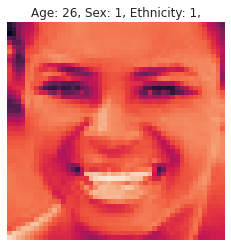

In [260]:
random_face = np.random.choice(len(df_regression))
age = df_regression['age'][random_face]
ethnicity = df_regression['ethnicity'][random_face]
gender = df_regression['gender'][random_face]
plt.imshow(df_regression['pixels'][random_face])
plt.title('Age: {0}, Sex: {1}, Ethnicity: {2},'.format(age, gender, ethnicity))
plt.axis('off');

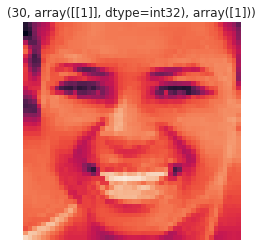

In [261]:
face_prediction(df_regression['pixels'][random_face])